In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import torch
# Does this fix the hdf5 multiprocessing bug?
torch.multiprocessing.set_start_method("spawn")

# !git clone https://github.com/guydav/deep-learning-projects.git
# !pip install -q -r deep-learning-projects/requirements.txt
!wandb login 9676e3cc95066e4865586082971f2653245f09b4
sys.path.extend(('/home/cc/deep-learning-projects', '/home/cc/src/tqdm'))

Appending key for api.wandb.ai to your netrc file: /home/cc/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import projects
from projects.metalearning import *

## Load the dataset

This time with 3x the batch size, 1.5k

In [4]:
ML_50K = '/home/cc/meta_learning_50k.h5'

normalized_train_dataset, train_dataloader, normalized_test_dataset, test_dataloader = \
        create_normalized_datasets(dataset_path=ML_50K, 
                                   batch_size=1500,
                                   num_workers=4,
                                   downsample_size=None,
                                   should_flip=False,
                                   return_indices=False,
                                   dataset_class_kwargs=dict(
                                       num_dimensions=3,
                                       features_per_dimension=(10, 10, 10)
                                   ))

Splitting test-train at 45000
Loaded normalization from cache
[0.4644661  0.45839542 0.45069984]
[0.11204559 0.11298621 0.12539756]


In [ ]:
current_epoch = 0
save_dir = '/home/cc/checkpoints'

summary_model = PoolingDropoutCNNMLP(
    query_length=30,
    conv_filter_sizes=(16, 32, 48, 64),
    conv_output_size=4480, 
    mlp_layer_sizes=(512, 512, 512, 512),
    lr=5e-4, 
    weight_decay=1e-4, 
    conv_dropout=False,
    mlp_dropout=False,
    name='summary',
    save_dir=save_dir)

summary_model.load_model(current_epoch)
summary_model = summary_model.cuda()
summary(summary_model, [(3, 160, 120), (30, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 120]             448
       BatchNorm2d-2         [-1, 16, 160, 120]              32
            Conv2d-3           [-1, 32, 80, 60]           4,640
       BatchNorm2d-4           [-1, 32, 80, 60]              64
            Conv2d-5           [-1, 48, 40, 30]          13,872
       BatchNorm2d-6           [-1, 48, 40, 30]              96
            Conv2d-7           [-1, 64, 20, 15]          27,712
       BatchNorm2d-8           [-1, 64, 20, 15]             128
PoolingDropoutConvInputModel-9            [-1, 64, 10, 7]               0
           Linear-10                  [-1, 512]       2,309,632
           Linear-11                  [-1, 512]         262,656
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 512]         262,656
           Linear-14         

In [ ]:
current_epoch = 0
save_dir = '/home/cc/checkpoints'

query_modulating_model = QueryModulatingCNNMLP(
    mod_level=2,
    query_length=30,
    conv_filter_sizes=(16, 32, 48, 64),
    conv_output_size=4480, 
    mlp_layer_sizes=(512, 512, 512, 512),
    lr=5e-4, 
    weight_decay=1e-4, 
    conv_dropout=False,
    mlp_dropout=False,
    name='query_modulating_cnn_mlp2',
    save_dir=save_dir)

query_modulating_model.load_model(current_epoch)
query_modulating_model = query_modulating_model.cuda()

In [ ]:
summary(query_modulating_model, [(3, 160, 120), (30, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             992
            Conv2d-2         [-1, 16, 160, 120]             448
       BatchNorm2d-3         [-1, 16, 160, 120]              32
            Conv2d-4           [-1, 32, 80, 60]           4,640
       BatchNorm2d-5           [-1, 32, 80, 60]              64
            Conv2d-6           [-1, 48, 40, 30]          13,872
       BatchNorm2d-7           [-1, 48, 40, 30]              96
            Conv2d-8           [-1, 64, 20, 15]          27,712
       BatchNorm2d-9           [-1, 64, 20, 15]             128
QueryModulatingPoolingDropoutConvInputModel-10            [-1, 64, 10, 7]               0
           Linear-11                  [-1, 512]       2,309,632
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 512]         262,656
           Li

In [ ]:
# os.environ['WANDB_RUN_ID'] ='98w3kzlw'
# os.environ['WANDB_RESUME'] = 'must'
wandb.init(entity='meta-learning-scaling', project='sequential-benchmark') #, resume=True)

current_model = query_modulating_model

wandb.config.lr = current_model.lr
wandb.config.decay = current_model.weight_decay
wandb.config.loss = 'CE'
wandb.config.batch_size = train_dataloader.batch_size

W&B Run: https://app.wandb.ai/meta-learning-scaling/sequential-benchmark/runs/b7p1cuhy
Call `%%wandb` in the cell containing your training loop to display live results.


2019-03-07 23:18:13: After epoch 1, TRAIN acc is 72.2922, loss is 0.4568, AUC is 0.7174
2019-03-07 23:19:10: After epoch 1, TEST acc is 81.2800, loss is 0.3241, AUC is 0.8158


wandb: Wandb version 0.7.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2019-03-07 23:29:34: After epoch 2, TRAIN acc is 84.7600, loss is 0.2703, AUC is 0.8491
2019-03-07 23:30:28: After epoch 2, TEST acc is 87.2500, loss is 0.2267, AUC is 0.8772
2019-03-07 23:40:49: After epoch 3, TRAIN acc is 89.1356, loss is 0.1985, AUC is 0.8941
2019-03-07 23:41:42: After epoch 3, TEST acc is 90.6800, loss is 0.1743, AUC is 0.9094
2019-03-07 23:52:08: After epoch 4, TRAIN acc is 92.1956, loss is 0.1471, AUC is 0.9254
2019-03-07 23:53:04: After epoch 4, TEST acc is 93.2100, loss is 0.1281, AUC is 0.9354
2019-03-08 00:03:26: After epoch 5, TRAIN acc is 94.0456, loss is 0.1129, AUC is 0.9441
2019-03-08 00:04:21: After epoch 5, TEST acc is 94.5300, loss is 0.1024, AUC is 0.9512
2019-03-08 00:14:44: After epoch 6, TRAIN acc is 95.1611, loss is 0.0907, AUC is 0.9554
2019-03-08 00:15:39: After epoch 6, TEST acc is 95.0500, loss is 0.0953, AUC is 0.9543
2019-03-08 00:26:00: After epoch 7, TRAIN acc is 95.9233, loss is 0.0745, AUC is 0.9632
2019-03-08 00:26:54: After epoch 7, T

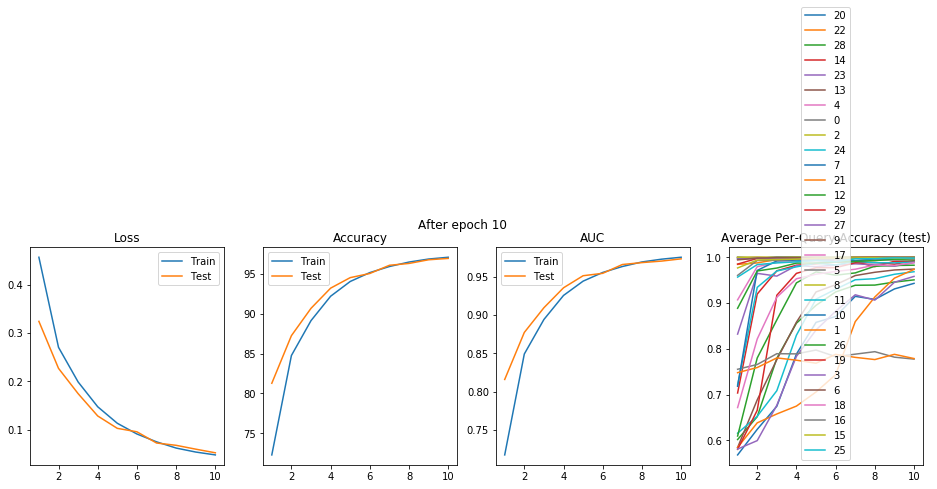

2019-03-08 01:11:07: After epoch 11, TRAIN acc is 97.2789, loss is 0.0436, AUC is 0.9771
2019-03-08 01:12:00: After epoch 11, TEST acc is 97.0200, loss is 0.0499, AUC is 0.9749
2019-03-08 01:22:21: After epoch 12, TRAIN acc is 97.4178, loss is 0.0404, AUC is 0.9785
2019-03-08 01:23:16: After epoch 12, TEST acc is 97.1500, loss is 0.0474, AUC is 0.9762


In [ ]:
total_epochs = 200
wandb.config.update(dict(epochs=total_epochs), allow_val_change=True)

train(query_modulating_model, train_dataloader, test_dataloader, 
      num_epochs=total_epochs - current_epoch, epochs_to_test=1, epochs_to_graph=10, 
      num_batches_to_print=10000, start_epoch=current_epoch)

In [ ]:
x = torch.empty(32, 1, 1).cuda()
y = torch.empty(100, 32, 80, 60).cuda()

In [ ]:
z = x[:,None,None] + y

In [ ]:
x.shape

In [ ]:
l = torch.nn.Linear(2, 10)
r = torch.rand(2)
o = l(r)

In [ ]:
o.shape

In [ ]:
o[:,None,None].shape